
# <p style="text-align:center"> <font color='darkorange'>**CUNEF**</font>
## <p style="text-align:center"> **TFM - Análisis de sentimiento pólitico en Twitter**
### <p style="text-align:center"> **1. EDA y Selección/Preparación de variables**</strong><br />
    
<p style="text-align:left">Pablo Mazariegos Reviriego - <font color='orange'>pablo.mazariegos@cunef.edu </font>
    

En este proyecto de Trabajo Fin de Máster, realizaremos un análisis de sentimiento de los tweets hechos por los 5 candidatos políticos a la presidencia de Madrid durante el período de campaña política que abarcó desde el 12 hasta el 27 de mayo de 2023. Utilizaremos una base de datos recopilada manualmente que contiene los tweets de los candidatos. El objetivo principal de este proyecto es desarrollar modelos de aprendizaje automático que puedan clasificar los tweets según su sentimiento (positivo, negativo o neutral).

El proyecto se organizará en diferentes cuadernos, cada uno enfocado en una etapa específica del proceso:

 1. <font color='darkgreen'> **EDA y Selección/Preparación de variables**</font>
 2. Word Cloud y Análisis de viralidad
 3. Predicciones con GPT3
 4. Otros Modelos

Este cuaderno se enfoca en el análisis de datos de los tweets de los candidatos políticos durante la campaña electoral de Madrid. Realizaremos un análisis exploratorio de los datos, utilizando técnicas de visualización y evaluando el sentimiento político expresado en los tweets. Además, emplearemos un modelo de sentimiento político previamente entrenado para clasificar los tweets en categorías de sentimiento. Compartiremos nuestros resultados a través de visualizaciones informativas y resumidas, lo que nos permitirá obtener una comprensión más profunda de las opiniones y actitudes de los usuarios durante la campaña política.

  **INDICE:**
 
 - [Importación de Librerias](#0) 
 - [Funciones utilizadas en este notebook](#1) 
 - [Carga de datos](#2)
 - [Exploración de los datos](#3)
 - [Modelo de Sentimiento Pólitico](#4)
 - [Preprocesado de los tweets](#8)


  **Correlación:**
 - [Correlación de las variables](#5)
 - [Spearman](#5.1)
 - [Cramer's V](#5.2)
 - [Pearson](#5.3)
 
 
 - [Exportación de los datos](#9)


##  <a name="0"> Importación de Librerias</a>

In [1]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as ss
from transformers import AutoModelForSequenceClassification
from transformers import TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
from scipy.special import softmax
import unidecode


import warnings
warnings.filterwarnings('ignore')

##  <a name="1">Funciones utilizadas en este notebook</a>

In [2]:
# Definimos una función para preprocesar cada tweet
def preprocess_tweet(tweet):
    # Solo procesamos si el input es de tipo string
    if isinstance(tweet, str):
        tweet = tweet.lower()  # Convertimos el tweet a minúsculas
      
        tweet_words = []
        # Recorremos cada palabra en el tweet
        for word in tweet.split(' '):
            # Si la palabra es una mención a un usuario, la reemplazamos por '@user'
            if word.startswith('@') and len(word) > 1:
                word = '@user'
            # Si la palabra es un enlace, la reemplazamos por 'http'
            elif word.startswith('http'):
                word = "http"
            # Añadimos la palabra a la lista de palabras del tweet
            tweet_words.append(word)

        # Devolvemos el tweet procesado
        return " ".join(tweet_words)
    else:
        # Si el input no es una string, devolvemos una string vacía
        return ""

In [3]:
# Definimos una función para analizar el sentimiento de un tweet
def analyze_sentiment(tweet):
    # Codificamos el tweet para que pueda ser procesado por el modelo
    encoded_tweet = tokenizer(tweet, return_tensors='pt')
    # Obtenemos las puntuaciones de sentimiento del modelo
    output = model(**encoded_tweet)
    # Convertimos las puntuaciones en un array de numpy
    scores = output[0][0].detach().numpy()
    # Convertimos las puntuaciones en probabilidades usando la función softmax
    scores = softmax(scores)
    # Devolvemos un diccionario que asocia cada etiqueta con su probabilidad
    return dict(zip(labels, scores))

In [4]:
def get_corr_matrix(dataset=None, metodo='spearman', size_figure=[10,8]):
    if dataset is None:
        print(u'\nHace falta pasar argumentos a la función')
        return 1
    sns.set(style="white")
    corr = dataset.corr(method=metodo)
    for i in range(corr.shape[0]):
        corr.iloc[i, i] = 0
    f, ax = plt.subplots(figsize=size_figure)
    sns.heatmap(corr, annot=True, fmt=".2f", square=True, linewidths=.5, cmap='coolwarm', vmin=-1, vmax=1)
    plt.show()


In [5]:
def cramers_v(var1,var2):
    """ 
    calculate Cramers V statistic for categorial-categorial association.
    uses correction from Bergsma and Wicher,
    Journal of the Korean Statistical Society 42 (2013): 323-328
    
    confusion_matrix: tabla creada con pd.crosstab()
    
    """
    crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None))
    chi2 = ss.chi2_contingency(crosstab)[0]
    n = crosstab.sum()
    phi2 = chi2 / n
    r, k = crosstab.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min((kcorr-1),(rcorr-1)))

##  <a name="2"> Carga de datos</a>

In [6]:
df = pd.read_excel('../data/raw/tweets_12-27Mayo.xlsx', usecols=lambda x: x != 'Nº')
df.head()

,PARTIDO,CANDIDATO,NICK,FOLLOWERS,FECHA,POST,VIDEO,FOTO,REPOST,RETWEET,WHO,COMMENTS,SHARED,LIKES,VIEWED,VOTOS,PORCENTAJE,ESCAÑOS
0,PP,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-12,"Comenzamos la campaña, una vez más, junto a la...",SI,NO,NO,NO,NaN,198,261,1260,58700,1586985,0.4734,70
1,PP,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-12,"Madrid es la región del Espíritu de Ermua, la ...",NO,NO,NO,NO,NaN,550,561,2127,101600,1586985,0.4734,70
2,PP,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-12,"Majadahonda con ganas de Libertad, familia, un...",NO,SI,NO,NO,NaN,140,213,1042,59700,1586985,0.4734,70
3,PP,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-13,❤️❤️,NO,SI,SI,NO,@cayetanaAT\n,155,343,2958,159100,1586985,0.4734,70
4,PP,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-13,Presidente: líbranos del mal.,NO,SI,NO,NO,NaN,893,549,2592,330800,1586985,0.4734,70


##  <a name="3"> Exploración de los datos</a>

In [7]:
print('Count of rows in the data is:  ', len(df))
print('Count of columns in the data is:  ', len(df.columns))
df.info()

Count of rows in the data is:   773
Count of columns in the data is:   18
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 773 entries, 0 to 772
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   PARTIDO     773 non-null    object        
 1   CANDIDATO   773 non-null    object        
 2   NICK        773 non-null    object        
 3   FOLLOWERS   773 non-null    int64         
 4   FECHA       773 non-null    datetime64[ns]
 5   POST        771 non-null    object        
 6   VIDEO       773 non-null    object        
 7   FOTO        773 non-null    object        
 8   REPOST      773 non-null    object        
 9   RETWEET     773 non-null    object        
 10  WHO         431 non-null    object        
 11  COMMENTS    773 non-null    int64         
 12  SHARED      773 non-null    int64         
 13  LIKES       773 non-null    int64         
 14  VIEWED      773 non-null    int64         
 15  

Comprobamos el total de nulos que hay en cada columna

In [8]:
df.isnull().sum()

PARTIDO         0
CANDIDATO       0
NICK            0
FOLLOWERS       0
FECHA           0
POST            2
VIDEO           0
FOTO            0
REPOST          0
RETWEET         0
WHO           342
COMMENTS        0
SHARED          0
LIKES           0
VIEWED          0
VOTOS           0
PORCENTAJE      0
ESCAÑOS         0
dtype: int64

In [9]:
df.replace({'VIDEO': {'NO': False, 'SI': True},
            'FOTO': {'NO': False, 'SI': True},
            'REPOST': {'NO': False, 'SI': True},
            'RETWEET': {'NO': False, 'SI': True},
            'WHO': {np.nan: False}}, inplace=True)

Visualizamos las dos filas que tienen nulos

In [10]:
df[df.isnull().any(axis=1)]

,PARTIDO,CANDIDATO,NICK,FOLLOWERS,FECHA,POST,VIDEO,FOTO,REPOST,RETWEET,WHO,COMMENTS,SHARED,LIKES,VIEWED,VOTOS,PORCENTAJE,ESCAÑOS
178,PSOE,Juan Lobato,@juanlobato_es\n,25500,2023-05-26,NaN,False,True,False,False,False,74,101,223,5460,609718,0.1819,27
486,VOX,Rocío Monasterio,@monasterioR,339700,2023-05-20,NaN,True,False,False,True,@alonso_dm\n,4,119,272,28600,245215,0.0731,10


En Ambos casos son fotos o repost de una foto por lo tanto eliminamos las filas

In [11]:
#Al cargar los datos crea una fila de nulos
df = df.drop([178, 486])
print('Count of rows in the data is:  ', len(df))
print('Count of columns in the data is:  ', len(df.columns))

Count of rows in the data is:   771
Count of columns in the data is:   18


**Comprobamos Duplicados**

In [12]:
df.duplicated().sum()

2

In [13]:
# Obtén un DataFrame que contiene solo las filas duplicadas
duplicated_rows = df[df.duplicated()]

# Muestra las filas duplicadas
print(duplicated_rows)

    PARTIDO         CANDIDATO               NICK  FOLLOWERS      FECHA  \
529     VOX  Rocío Monasterio       @monasterioR     339700 2023-05-25   
595    PSOE       Juan Lobato   @juanlobato_es\n      25500 2023-05-26   

                                                  POST  VIDEO   FOTO  REPOST  \
529  Intenta dar lecciones de gestión y no sabe ges...   True  False   False   
595  Mi último mensaje, mi prioridad. \n\nQuiero se...   True  False   False   

     RETWEET    WHO  COMMENTS  SHARED  LIKES  VIEWED   VOTOS  PORCENTAJE  \
529    False  False       123     648   1619   29000  245215      0.0731   
595    False  False       248     359    615   18100  609718      0.1819   

     ESCAÑOS  
529       10  
595       27  


No hay Duplicados relevantes.

Volvemos a comprobar los datos

In [14]:
print('Count of rows in the data is:  ', len(df))
print('Count of columns in the data is:  ', len(df.columns))
df.info()
df.isnull().sum()

Count of rows in the data is:   771
Count of columns in the data is:   18
<class 'pandas.core.frame.DataFrame'>
Int64Index: 771 entries, 0 to 772
Data columns (total 18 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   PARTIDO     771 non-null    object        
 1   CANDIDATO   771 non-null    object        
 2   NICK        771 non-null    object        
 3   FOLLOWERS   771 non-null    int64         
 4   FECHA       771 non-null    datetime64[ns]
 5   POST        771 non-null    object        
 6   VIDEO       771 non-null    bool          
 7   FOTO        771 non-null    bool          
 8   REPOST      771 non-null    bool          
 9   RETWEET     771 non-null    bool          
 10  WHO         771 non-null    object        
 11  COMMENTS    771 non-null    int64         
 12  SHARED      771 non-null    int64         
 13  LIKES       771 non-null    int64         
 14  VIEWED      771 non-null    int64         
 15  

PARTIDO       0
CANDIDATO     0
NICK          0
FOLLOWERS     0
FECHA         0
POST          0
VIDEO         0
FOTO          0
REPOST        0
RETWEET       0
WHO           0
COMMENTS      0
SHARED        0
LIKES         0
VIEWED        0
VOTOS         0
PORCENTAJE    0
ESCAÑOS       0
dtype: int64

**Distribución de los datos**

In [15]:
# Calcular el número de tweets por partido
tweets_por_partido = df['PARTIDO'].value_counts().reset_index()
tweets_por_partido.columns = ['PARTIDO', 'NUM_TWEETS']

# Calcular el porcentaje de tweets por partido
total_tweets = df['PARTIDO'].count()
tweets_por_partido['PORCENTAJE'] = (tweets_por_partido['NUM_TWEETS'] / total_tweets) * 100

# Mostrar el resultado
print(tweets_por_partido)

      PARTIDO  NUM_TWEETS  PORCENTAJE
0  MÁS MADRID         223   28.923476
1         VOX         202   26.199741
2     PODEMOS         197   25.551232
3        PSOE          95   12.321660
4          PP          54    7.003891


##  <a name="4">Modelo de Sentimiento Pólitico</a>

Para añadir el sentimiento de los Post, utilizo un modelo ya entrenado "cardiffnlp/xlm-twitter-politics-sentiment".

Esta es una "extensión" del modelo multilingüe twitter-xlm-roberta-base-sentiment (modelo, artículo original) con un enfoque en el sentimiento de los tweets de los políticos. El ajuste fino del sentimiento original se realizó en 8 idiomas (Ar, En, Fr, De, Hi, It, Sp, Pt), pero se realizó un entrenamiento adicional utilizando tweets de Miembros del Parlamento del Reino Unido (inglés), España (español) y Grecia (griego). Este modelo cuenta con datos hasta el año 2021.

**Se puede encontrar aqui:** https://huggingface.co/cardiffnlp/xlm-twitter-politics-sentiment

**Modelo base Roberta** 

Este es un modelo multilingüe XLM-roBERTa-base entrenado en aproximadamente 198 millones de tweets y afinado para el análisis de sentimientos. El ajuste fino del sentimiento se realizó en 8 idiomas (Ar, En, Fr, De, Hi, It, Sp, Pt), pero puede utilizarse para más idiomas (ver el artículo para más detalles). Este modelo ha sido entrenado con datos hasta el año 2020.

**Se puede encontrar aqui:** https://huggingface.co/cardiffnlp/twitter-xlm-roberta-base-sentiment

## Limpieza de tweets

In [17]:
# Copio la columna POST a post_clean para guardar las transformaciones
df['post_clean'] = df['POST'].copy()
# Convierte la columna post a minúsculas
df['post_clean'] = df['post_clean'].str.lower()
# Borramos los usuarios de los posts
df['post_clean'] = df['post_clean'].str.replace('@[^\s]+','')
# Borrado de signos de puntuación
df['post_clean'] = df['post_clean'].apply(lambda x: unidecode.unidecode(x) if pd.notnull(x) else x)
# Reemplazar los saltos de línea en la columna "post_clean" con espacios en blanco
df['post_clean'] = df['post_clean'].replace('\n', ' ', regex=True)
# Aplicar el método str.strip() a la columna "post_clean" en el dataframe "df"
df['post_clean'] = df['post_clean'].str.strip()
# Borrado de emojis
df['post_clean'] = df['post_clean'].str.replace('[^\x00-\x7F]+','')
# Borrado de Links
df['post_clean'] = df['post_clean'].str.replace('http\S+|www.\S+','')
# Mostrar los primeros registros de la columna "post_clean"
print(df['post_clean'].head())

0    comenzamos la campana, una vez mas, junto a la...
1    madrid es la region del espiritu de ermua, la ...
2    majadahonda con ganas de libertad, familia, un...
3                                                     
4                        presidente: libranos del mal.
Name: post_clean, dtype: object


In [19]:
# Definimos el nombre del modelo pre-entrenado que vamos a utilizar
MODEL = "cardiffnlp/xlm-twitter-politics-sentiment"
# Cargamos el modelo para la clasificación de secuencias 
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
# Cargamos el tokenizador asociado a este modelo
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [20]:
# Extraemos la columna 'POST' del DataFrame original para trabajar con ella
df_post = df['post_clean']
# Definimos las etiquetas que usará el modelo para la clasificación
labels = ['Negative', 'Neutral', 'Positive']

In [21]:
# Aplicamos la función de preprocesamiento a cada tweet
df_post['processed_text'] = df_post.apply(preprocess_tweet)

In [22]:
# Aplicamos la función de análisis de sentimiento a cada tweet procesado
df_post['sentiment_analysis'] = df_post['processed_text'].apply(analyze_sentiment)

In [23]:
sentimiento_df = df_post['sentiment_analysis'].apply(pd.Series)
sentimiento_df['sentimiento'] = sentimiento_df.idxmax(axis=1)
sentimiento_df.head()

,Negative,Neutral,Positive,sentimiento
0,0.036168,0.037217,0.926616,Positive
1,0.903652,0.060031,0.036317,Negative
2,0.012935,0.017331,0.969734,Positive
3,0.329005,0.321286,0.349709,Positive
4,0.283729,0.143937,0.572334,Positive


##  <a name="8"> Preprocesado de los tweets</a>

In [25]:
df = pd.concat([df, sentimiento_df], axis=1)

In [26]:
# Creamos columnas de porcentages para un mejor Analisis dividimos entre nomreo de visitas
df['COMMENTS vs VIEWED'] = df['COMMENTS'] / df['VIEWED']
df['SHARED vs VIEWED'] = df['SHARED'] / df['VIEWED']
df['LIKES vs VIEWED'] = df['LIKES'] / df['VIEWED']

# Convertir la columna 'fecha' a datetime
df['FECHA'] = pd.to_datetime(df['FECHA'])

# Convertir las columnas 'video', 'repost', 'retweet' a booleanos
df['FOTO'] = df['FOTO'].astype(bool)
df['VIDEO'] = df['VIDEO'].astype(bool)
df['REPOST'] = df['REPOST'].astype(bool)
df['RETWEET'] = df['RETWEET'].astype(bool)

In [28]:
# Pasamos la columna de sentimiento a minuscila
df['sentimiento'] = df['sentimiento'].str.lower()

In [29]:
#creo una nueva columna "sentimiento_num" numerica que represente el sentimie'neutral': 1, 'positive': 2, 'negative': 0 
df['sentimiento_num'] = df['sentimiento'].copy()
# Convierto el sentimiento a valores numericos.
df['sentimiento_num'] = df['sentimiento_num'].map({'neutral': 1, 'positive': 2, 'negative': 0})

In [30]:
# Definir el mapeo de partidos a valores numéricos
partidos_numericos = {'MÁS MADRID': 0, 'VOX': 1, 'PODEMOS': 2, 'PSOE': 3, 'PP': 4}
# Crear una nueva columna numérica a partir de la columna de partidos
df['partido_num'] = df['PARTIDO'].map(partidos_numericos)

In [31]:
# Borrado de signos de puntuación 
df['PARTIDO'] = df['PARTIDO'].apply(lambda x: unidecode.unidecode(x) if pd.notnull(x) else x)
# Pasamos la columna de partido a minuscula
df['PARTIDO'] = df['PARTIDO'].str.lower()
# Quitamos acentos a la columna partido
df['PARTIDO'] = df['PARTIDO'].apply(lambda x: unidecode.unidecode(x) if pd.notnull(x) else x)

In [32]:
#Reorganización de las columnas
column_order = ['PARTIDO', 'partido_num', 'CANDIDATO', 'NICK', 'FOLLOWERS', 'FECHA', 'POST', 'post_clean', 'sentimiento', 
                'sentimiento_num', 'Negative', 'Neutral', 'Positive', 'VIDEO', 'FOTO', 'REPOST', 'RETWEET', 'WHO', 'VIEWED',
                'COMMENTS', 'COMMENTS vs VIEWED', 'SHARED', 'SHARED vs VIEWED', 'LIKES', 'LIKES vs VIEWED', 'VOTOS',
                'PORCENTAJE', 'ESCAÑOS']

df = df.reindex(columns=column_order)

In [33]:
# Convertir los nombres de las columnas a minúsculas
df.columns = df.columns.str.lower()

Última visualización del data Frame antes de su exportación

In [34]:
df.head()

,partido,partido_num,candidato,nick,followers,fecha,post,post_clean,sentimiento,sentimiento_num,...,viewed,comments,comments vs viewed,shared,shared vs viewed,likes,likes vs viewed,votos,porcentaje,escaños
0,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-12,"Comenzamos la campaña, una vez más, junto a la...","comenzamos la campana, una vez mas, junto a la...",positive,2,...,58700,198,0.003373,261,0.004446,1260,0.021465,1586985,0.4734,70
1,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-12,"Madrid es la región del Espíritu de Ermua, la ...","madrid es la region del espiritu de ermua, la ...",negative,0,...,101600,550,0.005413,561,0.005522,2127,0.020935,1586985,0.4734,70
2,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-12,"Majadahonda con ganas de Libertad, familia, un...","majadahonda con ganas de libertad, familia, un...",positive,2,...,59700,140,0.002345,213,0.003568,1042,0.017454,1586985,0.4734,70
3,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-13,❤️❤️,,positive,2,...,159100,155,0.000974,343,0.002156,2958,0.018592,1586985,0.4734,70
4,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-13,Presidente: líbranos del mal.,presidente: libranos del mal.,positive,2,...,330800,893,0.002700,549,0.001660,2592,0.007836,1586985,0.4734,70


# **Correlación**

 ##  <a name="5"> Correlación de las variables</a> 

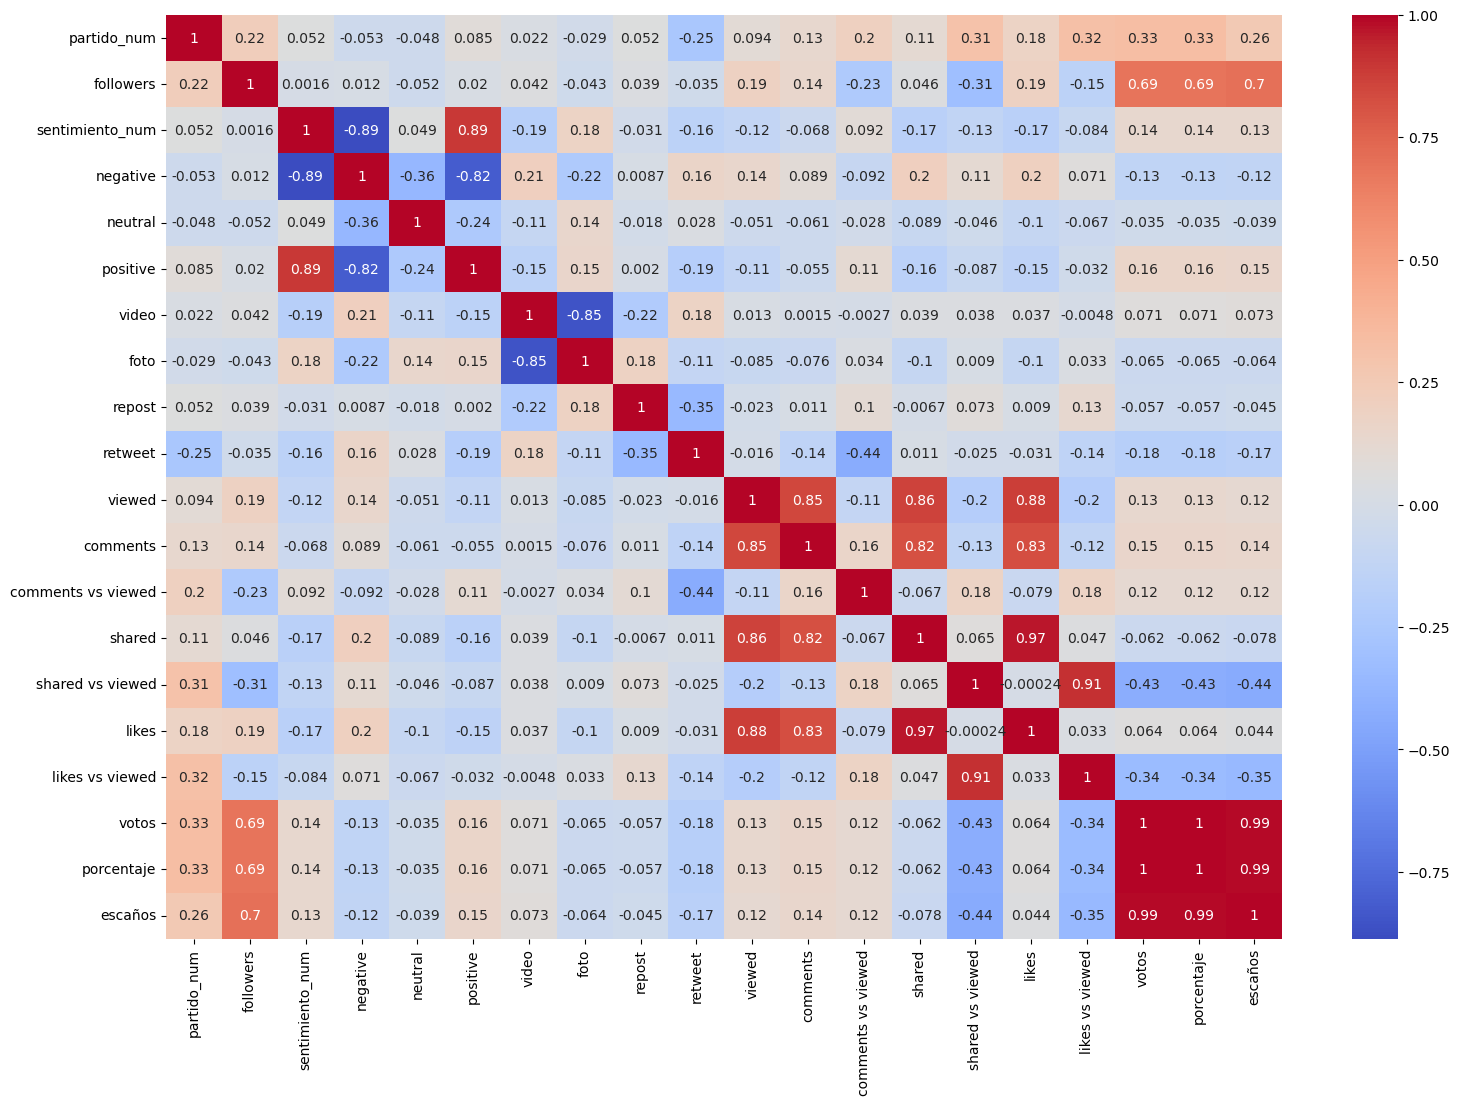

In [36]:
plt.figure(figsize=(18, 12))  # Tamaño personalizado en pulgadas (ancho, alto)
correlation = df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm')
plt.show()

In [37]:
correlation = df.corr()
print(correlation)

                    partido_num  followers  sentimiento_num  negative  \
partido_num            1.000000   0.220870         0.051762 -0.053047   
followers              0.220870   1.000000         0.001556  0.012021   
sentimiento_num        0.051762   0.001556         1.000000 -0.886596   
negative              -0.053047   0.012021        -0.886596  1.000000   
neutral               -0.047634  -0.052151         0.049469 -0.364490   
positive               0.084700   0.019571         0.894865 -0.819219   
video                  0.021641   0.042213        -0.185581  0.208866   
foto                  -0.029276  -0.042747         0.177849 -0.223630   
repost                 0.051929   0.039000        -0.031469  0.008719   
retweet               -0.253972  -0.035205        -0.157013  0.164025   
viewed                 0.094090   0.192871        -0.115975  0.138493   
comments               0.133668   0.138393        -0.067617  0.089196   
comments vs viewed     0.200261  -0.226601         

In [38]:
correlation = df.corr().abs()  # Calcula la matriz de correlación con valores absolutos
mask = np.triu(np.ones_like(correlation, dtype=bool))  # Crea una máscara triangular superior
correlation = correlation.mask(mask)  # Aplica la máscara para obtener solo la mitad inferior de la matriz
max_corr = correlation.max()  # Encuentra los valores máximos de correlación
max_corr_vars = max_corr[max_corr > 0.8].index  # Filtra las variables con correlación mayor a 0.8
print(max_corr_vars)

Index(['sentimiento_num', 'negative', 'video', 'viewed', 'comments', 'shared',
       'shared vs viewed', 'votos', 'porcentaje'],
      dtype='object')


In [39]:
correlation = df.corr().abs()  # Calcula la matriz de correlación con valores absolutos
mask = np.triu(np.ones_like(correlation, dtype=bool))  # Crea una máscara triangular superior
correlation = correlation.mask(mask)  # Aplica la máscara para obtener solo la mitad inferior de la matriz
min_corr = correlation.min()  # Encuentra los valores mínimos de correlación
min_corr_vars = min_corr[min_corr < 0.2].index  # Filtra las variables con correlación menor a 0.2
print(min_corr_vars)

Index(['partido_num', 'followers', 'sentimiento_num', 'negative', 'neutral',
       'positive', 'video', 'foto', 'repost', 'retweet', 'viewed', 'comments',
       'comments vs viewed', 'shared', 'shared vs viewed', 'likes'],
      dtype='object')


## <a name="5.1">Spearman</a> 

In [58]:
df_spearman = df[['partido', 'partido_num', 'candidato', 'nick', 'followers', 'fecha',
       'post', 'post_clean', 'sentimiento', 'sentimiento_num', 'negative', 'neutral', 'positive', 'video',
       'foto', 'repost', 'retweet', 'viewed', 'comments', 'comments vs viewed',
       'shared', 'shared vs viewed', 'likes', 'likes vs viewed', 'votos',
       'porcentaje', 'escaños']]

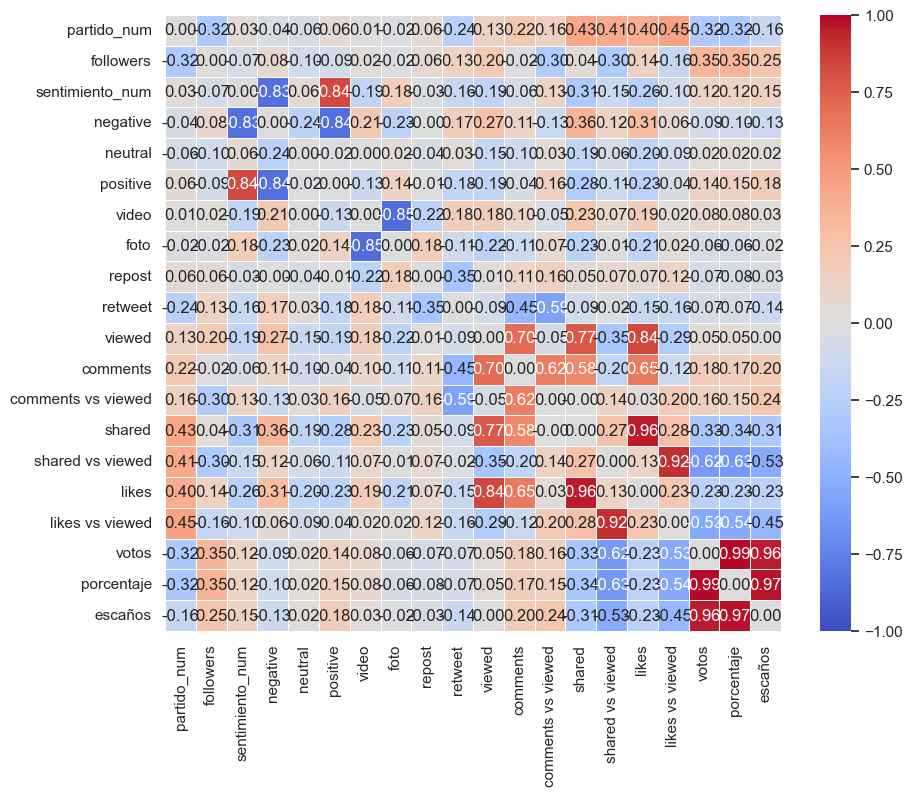

In [59]:
get_corr_matrix(dataset = df_spearman, size_figure = [10,8])

In [42]:
spearman = df_spearman.corr(method = 'spearman')
print(spearman)

                    partido_num  followers  sentimiento_num  negative  \
partido_num            1.000000  -0.316844         0.032954 -0.040109   
followers             -0.316844   1.000000        -0.071640  0.082953   
sentimiento_num        0.032954  -0.071640         1.000000 -0.828647   
negative              -0.040109   0.082953        -0.828647  1.000000   
neutral               -0.063370  -0.101340         0.055064 -0.242909   
positive               0.057165  -0.087648         0.835859 -0.838619   
video                  0.010952   0.021063        -0.188596  0.213559   
foto                  -0.019667  -0.018294         0.181991 -0.229163   
repost                 0.061451   0.057898        -0.031281 -0.000447   
retweet               -0.236568   0.125638        -0.156089  0.170869   
viewed                 0.133321   0.200869        -0.194376  0.270203   
comments               0.223502  -0.016398        -0.056496  0.114976   
comments vs viewed     0.161251  -0.295089         

In [43]:
correlation = spearman.corr().abs()  # Calcula la matriz de correlación con valores absolutos
mask = np.triu(np.ones_like(correlation, dtype=bool))  # Crea una máscara triangular superior
correlation = correlation.mask(mask)  # Aplica la máscara para obtener solo la mitad inferior de la matriz
max_corr = correlation.max()  # Encuentra los valores máximos de correlación
max_corr_vars = max_corr[max_corr > 0.8].index  # Filtra las variables con correlación mayor a 0.8
print(max_corr_vars)

Index(['sentimiento_num', 'negative', 'video', 'retweet', 'viewed', 'shared',
       'shared vs viewed', 'likes vs viewed', 'votos', 'porcentaje'],
      dtype='object')


In [44]:
correlation = spearman.corr().abs()  # Calcula la matriz de correlación con valores absolutos
mask = np.triu(np.ones_like(correlation, dtype=bool))  # Crea una máscara triangular superior
correlation = correlation.mask(mask)  # Aplica la máscara para obtener solo la mitad inferior de la matriz
min_corr = correlation.min()  # Encuentra los valores mínimos de correlación
min_corr_vars = min_corr[min_corr < 0.2].index  # Filtra las variables con correlación menor a 0.2
print(min_corr_vars)

Index(['partido_num', 'followers', 'sentimiento_num', 'negative', 'neutral',
       'positive', 'video', 'foto', 'repost', 'retweet', 'viewed', 'comments',
       'comments vs viewed'],
      dtype='object')


## <a name="5.2">Cramer's V</a> 

In [45]:
df_categorical_variables = df[['partido', 'partido_num', 'candidato', 'nick', 'sentimiento', 'sentimiento_num', 'video',
                                               'foto', 'repost', 'retweet']]


<Axes: >

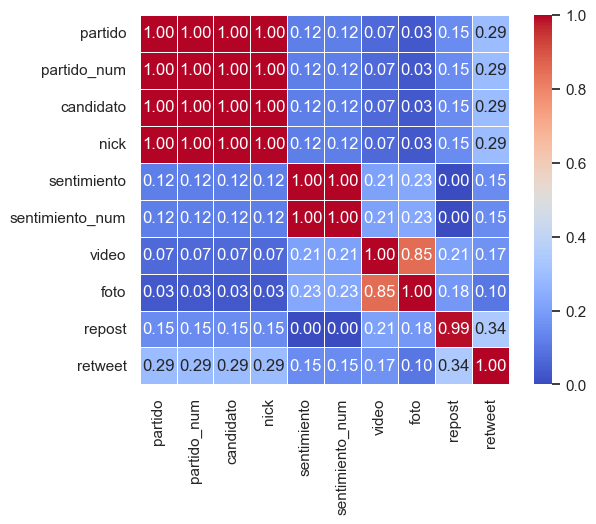

In [46]:
rows = []
for var1 in df_categorical_variables :
  col = []
  for var2 in df_categorical_variables :
    cramers = cramers_v(df_categorical_variables[var1], df_categorical_variables[var2]) # Cramer's V test
    col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
  rows.append(col)
  
cramers_results = np.array(rows)
df_vcramer = pd.DataFrame(cramers_results, columns = df_categorical_variables .columns,
                          index = df_categorical_variables .columns)

sns.heatmap(df_vcramer, vmin=0, vmax=1, square=True, annot=True, linewidths=.5, cmap='coolwarm', fmt=".2f")


In [47]:
df_vcramer

,partido,partido_num,candidato,nick,sentimiento,sentimiento_num,video,foto,repost,retweet
partido,1.00,1.00,1.00,1.00,0.12,0.12,0.07,0.03,0.15,0.29
partido_num,1.00,1.00,1.00,1.00,0.12,0.12,0.07,0.03,0.15,0.29
candidato,1.00,1.00,1.00,1.00,0.12,0.12,0.07,0.03,0.15,0.29
nick,1.00,1.00,1.00,1.00,0.12,0.12,0.07,0.03,0.15,0.29
sentimiento,0.12,0.12,0.12,0.12,1.00,1.00,0.21,0.23,0.00,0.15
sentimiento_num,0.12,0.12,0.12,0.12,1.00,1.00,0.21,0.23,0.00,0.15
video,0.07,0.07,0.07,0.07,0.21,0.21,1.00,0.85,0.21,0.17
foto,0.03,0.03,0.03,0.03,0.23,0.23,0.85,1.00,0.18,0.10
repost,0.15,0.15,0.15,0.15,0.00,0.00,0.21,0.18,0.99,0.34
retweet,0.29,0.29,0.29,0.29,0.15,0.15,0.17,0.10,0.34,1.00


In [48]:
correlation = df_vcramer.corr().abs()  # Calcula la matriz de correlación con valores absolutos
mask = np.triu(np.ones_like(correlation, dtype=bool))  # Crea una máscara triangular superior
correlation = correlation.mask(mask)  # Aplica la máscara para obtener solo la mitad inferior de la matriz
max_corr = correlation.max()  # Encuentra los valores máximos de correlación
max_corr_vars = max_corr[max_corr > 0.8].index  # Filtra las variables con correlación mayor a 0.8
print(max_corr_vars)

Index(['partido', 'partido_num', 'candidato', 'sentimiento', 'video'], dtype='object')


In [49]:
correlation = df_vcramer.corr().abs()  # Calcula la matriz de correlación con valores absolutos
mask = np.triu(np.ones_like(correlation, dtype=bool))  # Crea una máscara triangular superior
correlation = correlation.mask(mask)  # Aplica la máscara para obtener solo la mitad inferior de la matriz
min_corr = correlation.min()  # Encuentra los valores mínimos de correlación
min_corr_vars = min_corr[min_corr < 0.2].index  # Filtra las variables con correlación menor a 0.2
print(min_corr_vars)

Index(['partido', 'partido_num', 'candidato', 'nick', 'sentimiento',
       'sentimiento_num', 'video', 'foto'],
      dtype='object')


##  <a name="5.3">Pearson</a>

In [50]:
df_continous_vairables = df[['followers', 'negative', 'neutral', 'positive', 'viewed', 'comments', 'comments vs viewed',
       'shared', 'shared vs viewed', 'likes', 'likes vs viewed', 'votos',
       'porcentaje', 'escaños']]
df_continous_vairables.head()

,followers,negative,neutral,positive,viewed,comments,comments vs viewed,shared,shared vs viewed,likes,likes vs viewed,votos,porcentaje,escaños
0,912100,0.036168,0.037217,0.926616,58700,198,0.003373,261,0.004446,1260,0.021465,1586985,0.4734,70
1,912100,0.903652,0.060031,0.036317,101600,550,0.005413,561,0.005522,2127,0.020935,1586985,0.4734,70
2,912100,0.012935,0.017331,0.969734,59700,140,0.002345,213,0.003568,1042,0.017454,1586985,0.4734,70
3,912100,0.329005,0.321286,0.349709,159100,155,0.000974,343,0.002156,2958,0.018592,1586985,0.4734,70
4,912100,0.283729,0.143937,0.572334,330800,893,0.002700,549,0.001660,2592,0.007836,1586985,0.4734,70


In [51]:
correlation = df_continous_vairables.corr().abs()  # Calcula la matriz de correlación con valores absolutos
mask = np.triu(np.ones_like(correlation, dtype=bool))  # Crea una máscara triangular superior
correlation = correlation.mask(mask)  # Aplica la máscara para obtener solo la mitad inferior de la matriz
max_corr = correlation.max()  # Encuentra los valores máximos de correlación
max_corr_vars = max_corr[max_corr > 0.8].index  # Filtra las variables con correlación mayor a 0.8
print(max_corr_vars)

Index(['negative', 'viewed', 'comments', 'shared', 'shared vs viewed', 'votos',
       'porcentaje'],
      dtype='object')


In [52]:
correlation = df_continous_vairables.corr().abs()  # Calcula la matriz de correlación con valores absolutos
mask = np.triu(np.ones_like(correlation, dtype=bool))  # Crea una máscara triangular superior
correlation = correlation.mask(mask)  # Aplica la máscara para obtener solo la mitad inferior de la matriz
min_corr = correlation.min()  # Encuentra los valores mínimos de correlación
min_corr_vars = min_corr[min_corr < 0.2].index  # Filtra las variables con correlación menor a 0.2
print(min_corr_vars)

Index(['followers', 'negative', 'neutral', 'positive', 'viewed', 'comments',
       'comments vs viewed', 'shared', 'shared vs viewed', 'likes'],
      dtype='object')


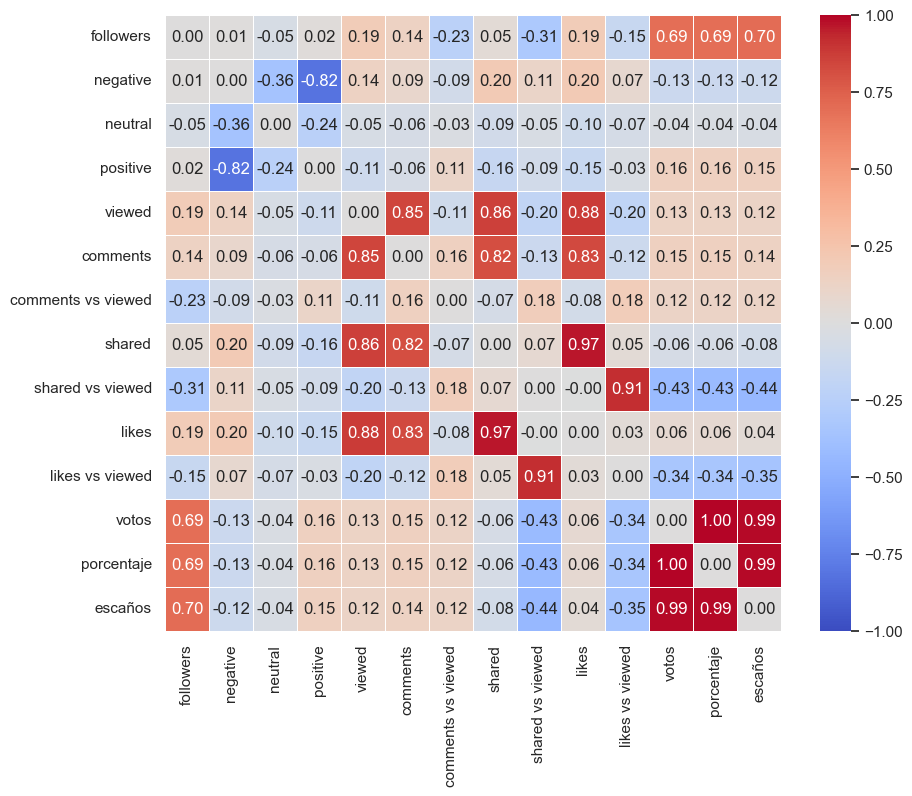

In [53]:
get_corr_matrix(dataset = df_continous_vairables,
                metodo = 'pearson', size_figure = [10,8])

##  <a name="9"> Exportación de los datos</a>

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 771 entries, 0 to 772
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   partido             771 non-null    object        
 1   partido_num         771 non-null    int64         
 2   candidato           771 non-null    object        
 3   nick                771 non-null    object        
 4   followers           771 non-null    int64         
 5   fecha               771 non-null    datetime64[ns]
 6   post                771 non-null    object        
 7   post_clean          771 non-null    object        
 8   sentimiento         771 non-null    object        
 9   sentimiento_num     771 non-null    int64         
 10  negative            771 non-null    float32       
 11  neutral             771 non-null    float32       
 12  positive            771 non-null    float32       
 13  video               771 non-null    bool          

In [54]:
df.head()

,partido,partido_num,candidato,nick,followers,fecha,post,post_clean,sentimiento,sentimiento_num,...,viewed,comments,comments vs viewed,shared,shared vs viewed,likes,likes vs viewed,votos,porcentaje,escaños
0,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-12,"Comenzamos la campaña, una vez más, junto a la...","comenzamos la campana, una vez mas, junto a la...",positive,2,...,58700,198,0.003373,261,0.004446,1260,0.021465,1586985,0.4734,70
1,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-12,"Madrid es la región del Espíritu de Ermua, la ...","madrid es la region del espiritu de ermua, la ...",negative,0,...,101600,550,0.005413,561,0.005522,2127,0.020935,1586985,0.4734,70
2,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-12,"Majadahonda con ganas de Libertad, familia, un...","majadahonda con ganas de libertad, familia, un...",positive,2,...,59700,140,0.002345,213,0.003568,1042,0.017454,1586985,0.4734,70
3,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-13,❤️❤️,,positive,2,...,159100,155,0.000974,343,0.002156,2958,0.018592,1586985,0.4734,70
4,pp,4,Isabel Díaz Ayuso,@IdiazAyuso,912100,2023-05-13,Presidente: líbranos del mal.,presidente: libranos del mal.,positive,2,...,330800,893,0.002700,549,0.001660,2592,0.007836,1586985,0.4734,70


Seexportan los datos como "df_sentimiento" y en la carpeta de preprocesado

In [55]:
df.to_csv('../data/processed/df_sentimiento.csv')

In [60]:
file_path = '../data/processed/df_sentimiento.csv'
df = pd.read_csv(file_path)


In [63]:
df.columns

Index(['Unnamed: 0', 'partido', 'partido_num', 'candidato', 'nick',
       'followers', 'fecha', 'post', 'post_clean', 'sentimiento',
       'sentimiento_num', 'negative', 'neutral', 'positive', 'video', 'foto',
       'repost', 'retweet', 'who', 'viewed', 'comments', 'comments vs viewed',
       'shared', 'shared vs viewed', 'likes', 'likes vs viewed', 'votos',
       'porcentaje', 'escaños'],
      dtype='object')

In [61]:
df["who"].head()

0             False
1             False
2             False
3     @cayetanaAT\n
4             False
Name: who, dtype: object